In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import torch
#from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from torch.utils.data import DataLoader
#from sentence_transformers import LoggingHandler
#from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
import numpy as np
import re

#from sklearn.metrics import roc_curve, auc

from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import roc_curve, auc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_folder = "C:\\Users\\gckc1\\Google Drive\\My programs\\Sierra\\full_auto_review_data\\20240618_manual_search"
model_folder = "C:\\Users\\gckc1\\Google Drive\\My programs\\Sierra\\model_training"
review_data_folder = "C:\\Users\\gckc1\\Google Drive\\My programs\Sierra\\full_auto_review_data\\20240618_manual_search\\Review files"

review_list = pd.read_csv(data_folder + "\\" + "manual_search_with_metadata_remove_contamination.csv")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
review_list["obj_sel"] = "[RTI] " + review_list["Review_title"] + " [BG] " + review_list["Background"].fillna("") + " [OBJ] " + review_list["Objective"].fillna("") + " [SEL] " + review_list["Selection_criteria"].fillna("")

In [5]:
model_ckpt = "dmis-lab/biobert-large-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [6]:
new_tokens = ["[RIT]", "[OBJ]", "[BG]", "[SEL]", "[TIT]", "[ABS]"]
num_added_toks = tokenizer.add_tokens(new_tokens)

In [7]:
import math
# Check if the new tokens are in the tokenizer
for token in new_tokens:
    if token in tokenizer.get_vocab():
        print(f"Token {token} is in the vocabulary.")
    else:
        print(f"Token {token} is not in the vocabulary.")

# Check the size of the new embeddings
print(f"New embedding size: {model.get_input_embeddings().num_embeddings}")

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of = 16)

Token [RIT] is in the vocabulary.
Token [OBJ] is in the vocabulary.
Token [BG] is in the vocabulary.
Token [SEL] is in the vocabulary.
Token [TIT] is in the vocabulary.
Token [ABS] is in the vocabulary.
New embedding size: 58996


Embedding(59008, 1024)

In [8]:
def token(df_input):
    df = Dataset.from_pandas(df_input.copy())
    for part in ["obj_sel", "tit_abs"]:
        df = df.map(
            lambda x:  tokenizer(
                x[part], max_length = 512, padding = True, truncation = True
            ), batched = True, batch_size = None
        )
        for col in ['input_ids', 'attention_mask']:
            df = df.rename_column(
                col, part+"_"+col
            )
    return(df)

In [9]:
model = torch.load(model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_biobert_relevance.pth', map_location = device)
ffnn = torch.load(model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_ffnn_relevance.pth', map_location = device)

if isinstance(model, torch.nn.DataParallel):
    model = model.module
    ffnn = ffnn.module

model = model.to(device)
ffnn = ffnn.to(device)

In [10]:
def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [11]:
def evaluate_model(model, ffnn, data_loader, device):
    model.eval()
    ffnn.eval()
    all_outputs = []
    predictions = []
    all_labels = []
    v_outputs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave = True):
            inputs_ids_a = batch['obj_sel_input_ids'].to(device)
            inputs_ids_b = batch['tit_abs_input_ids'].to(device)
            attention_a = batch['obj_sel_attention_mask'].to(device)
            attention_b = batch['tit_abs_attention_mask'].to(device)
        

            u = model(inputs_ids_a, attention_mask = attention_a)[0]
            v = model(inputs_ids_b, attention_mask = attention_b)[0]
            u = mean_pool(u, attention_a)
            v = mean_pool(v, attention_b)
            uv = torch.sub(u, v)
            uv_abs = torch.abs(uv)
            outputs = torch.cat([u, v, uv_abs], dim= -1)
            outputs = ffnn(outputs)
            
        
            all_outputs.append(outputs.cpu().numpy())
            v_outputs.append(v.cpu().numpy())
    all_outputs = np.vstack(all_outputs)
    return all_outputs, v_outputs

In [98]:
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range.csv")
    review = review[review['within_year_range']].copy()
    review['tit_abs'] = "[TIT] " + review["Title"].fillna("") + " [ABS] " + review["Abstract Note"].fillna("")
    review['obj_sel'] = review_record['obj_sel']
    review_set = token(review)
    all_cols = ['obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']
    review_set.set_format(type = 'torch', columns = all_cols)
    review_loader = DataLoader(review_set, batch_size = 32, shuffle = False)
    review_output, v = evaluate_model(model, ffnn, review_loader, device)
    #flatten_embedding = [embedding for sublist in v for embedding in sublist]
    review_output = review_output.squeeze()
    review["model_output"] = review_output
    review["model_decision"] = review["model_output"] > 0.423
    #review["embedding"] = flatten_embedding
    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    print(pd.crosstab(review["included"], review["model_decision"]))
    review.to_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred.csv")

******************************************************


Map:   0%|          | 0/2379 [00:00<?, ? examples/s]

Map:   0%|          | 0/2379 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

******************************************************
CD012155
model_decision  False  True 
included                    
False            1936    415
True                1     27
******************************************************


Map:   0%|          | 0/1787 [00:00<?, ? examples/s]

Map:   0%|          | 0/1787 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

******************************************************
CD015306
model_decision  False  True 
included                    
False            1717     64
True                0      6
******************************************************


Map:   0%|          | 0/12321 [00:00<?, ? examples/s]

Map:   0%|          | 0/12321 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/386 [00:00<?, ?it/s]

******************************************************
CD013822
model_decision  False  True 
included                    
False           11721    572
True                0     28
******************************************************


Map:   0%|          | 0/5967 [00:00<?, ? examples/s]

Map:   0%|          | 0/5967 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/187 [00:00<?, ?it/s]

******************************************************
CD012268
model_decision  False  True 
included                    
False            4347   1592
True                0     28
******************************************************


Map:   0%|          | 0/3544 [00:00<?, ? examples/s]

Map:   0%|          | 0/3544 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

******************************************************
CD015042
model_decision  False  True 
included                    
False            2855    677
True                0     12
******************************************************


Map:   0%|          | 0/52436 [00:00<?, ? examples/s]

Map:   0%|          | 0/52436 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/1639 [00:00<?, ?it/s]

******************************************************
CD014715
model_decision  False  True 
included                    
False           47587   4697
True               44    108
******************************************************


Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/91 [00:00<?, ?it/s]

******************************************************
CD013421
model_decision  False  True 
included                    
False            2306    552
True                0     30
******************************************************


Map:   0%|          | 0/2831 [00:00<?, ? examples/s]

Map:   0%|          | 0/2831 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]

******************************************************
CD015038
model_decision  False  True 
included                    
False            1724   1077
True                0     30
******************************************************


Map:   0%|          | 0/27709 [00:00<?, ? examples/s]

Map:   0%|          | 0/27709 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/866 [00:00<?, ?it/s]

******************************************************
CD013856
model_decision  False  True 
included                    
False            9544  17956
True                1    208
******************************************************


Map:   0%|          | 0/28277 [00:00<?, ? examples/s]

Map:   0%|          | 0/28277 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/884 [00:00<?, ?it/s]

******************************************************
CD013508
model_decision  False  True 
included                    
False           18564   9677
True                0     35
******************************************************


Map:   0%|          | 0/6510 [00:00<?, ? examples/s]

Map:   0%|          | 0/6510 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

******************************************************
CD005566
model_decision  False  True 
included                    
False            2889   3461
True                2    158
******************************************************


Map:   0%|          | 0/7563 [00:00<?, ? examples/s]

Map:   0%|          | 0/7563 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/237 [00:00<?, ?it/s]

******************************************************
CD013059
model_decision  False  True 
included                    
False            4298   3237
True                0     28
******************************************************


Map:   0%|          | 0/6924 [00:00<?, ? examples/s]

Map:   0%|          | 0/6924 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/217 [00:00<?, ?it/s]

******************************************************
CD013377
model_decision  False  True 
included                    
False            4732   2174
True                0     18
******************************************************


Map:   0%|          | 0/11535 [00:00<?, ? examples/s]

Map:   0%|          | 0/11535 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]

******************************************************
CD007569
model_decision  False  True 
included                    
False            9587   1925
True                0     23
******************************************************


Map:   0%|          | 0/12096 [00:00<?, ? examples/s]

Map:   0%|          | 0/12096 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/378 [00:00<?, ?it/s]

******************************************************
CD013880
model_decision  False  True 
included                    
False            8768   3284
True                0     44
******************************************************


Map:   0%|          | 0/14613 [00:00<?, ? examples/s]

Map:   0%|          | 0/14613 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/457 [00:00<?, ?it/s]

******************************************************
CD013591
model_decision  False  True 
included                    
False            8432   6138
True                1     42
******************************************************


Map:   0%|          | 0/5098 [00:00<?, ? examples/s]

Map:   0%|          | 0/5098 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?it/s]

******************************************************
CD013358
model_decision  False  True 
included                    
False            2173   2727
True                2    196
******************************************************


Map:   0%|          | 0/17517 [00:00<?, ? examples/s]

Map:   0%|          | 0/17517 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/548 [00:00<?, ?it/s]

******************************************************
CD005495
model_decision  False  True 
included                    
False           10699   6742
True                0     76
******************************************************


Map:   0%|          | 0/2745 [00:00<?, ? examples/s]

Map:   0%|          | 0/2745 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

******************************************************
CD013199
model_decision  False  True 
included                    
False            2014    715
True                0     16
******************************************************


Map:   0%|          | 0/3204 [00:00<?, ? examples/s]

Map:   0%|          | 0/3204 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

******************************************************
CD013197
model_decision  False  True 
included                    
False             605   2461
True                0    138
******************************************************


Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

******************************************************
CD008973
model_decision  False  True 
included                    
False            2248    204
True                0     42
******************************************************


Map:   0%|          | 0/5183 [00:00<?, ? examples/s]

Map:   0%|          | 0/5183 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/162 [00:00<?, ?it/s]

******************************************************
CD013295
model_decision  False  True 
included                    
False            1476   3420
True                1    286
******************************************************


Map:   0%|          | 0/12462 [00:00<?, ? examples/s]

Map:   0%|          | 0/12462 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/390 [00:00<?, ?it/s]

******************************************************
CD013071
model_decision  False  True 
included                    
False            7585   4777
True                2     98
******************************************************


Map:   0%|          | 0/959 [00:00<?, ? examples/s]

Map:   0%|          | 0/959 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

******************************************************
CD011218
model_decision  False  True 
included                    
False             721    220
True                0     18
******************************************************


Map:   0%|          | 0/3726 [00:00<?, ? examples/s]

Map:   0%|          | 0/3726 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/117 [00:00<?, ?it/s]

******************************************************
CD012693
model_decision  False  True 
included                    
False            2287   1414
True                0     25
******************************************************


Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/93 [00:00<?, ?it/s]

******************************************************
CD015432
model_decision  False  True 
included                    
False            1439   1426
True                0     84
******************************************************


Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/93 [00:00<?, ?it/s]

******************************************************
CD015067
model_decision  False  True 
included                    
False            1343   1593
True                1     19
******************************************************


Map:   0%|          | 0/7285 [00:00<?, ? examples/s]

Map:   0%|          | 0/7285 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/228 [00:00<?, ?it/s]

******************************************************
CD014736
model_decision  False  True 
included                    
False            6725    543
True                0     17
******************************************************


Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

******************************************************
CD013042
model_decision  False  True 
included                    
False             482    983
True                0     38
******************************************************


Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/59 [00:00<?, ?it/s]

******************************************************
CD013590
model_decision  False  True 
included                    
False            1752     83
True                2     26


In [12]:
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred.csv")

    review["model_decision_5"] = review["model_output"] > 0.492
    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    print(pd.crosstab(review["included"], review["model_decision_5"]))
    
    

******************************************************
******************************************************
CD012155
model_decision_5  False  True 
included                      
False              2012    339
True                  2     26
******************************************************
******************************************************
CD015306
model_decision_5  False  True 
included                      
False              1744     37
True                  2      4
******************************************************
******************************************************
CD013822
model_decision_5  False  True 
included                      
False             11947    346
True                  0     28
******************************************************
******************************************************
CD012268
model_decision_5  False  True 
included                      
False              4723   1216
True                  2     26
****************************

In [11]:
def calculate_embedding(model, data_loader, device):
    model.eval()
    v_outputs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave = True):
            inputs_ids_b = batch['tit_abs_input_ids'].to(device)
            attention_b = batch['tit_abs_attention_mask'].to(device)
            v = model(inputs_ids_b, attention_mask = attention_b)[0]
            v = mean_pool(v, attention_b)
            v_outputs.append(v.cpu().numpy())
    return v_outputs

In [104]:
from sentence_transformers import SentenceTransformer, util

for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred.csv")

    review_TF = review[(review["model_decision"] == True) & (review["included"] == False)].copy()
    review_T = review[(review["included"] == True)].copy()

    review_T_set = token(review_T)
    review_TF_set = token(review_TF)
    
    all_cols = ['obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']
    review_TF_set.set_format(type = 'torch', columns = all_cols)
    review_TF_loader = DataLoader(review_TF_set, batch_size = 32, shuffle = False)
    
    v = calculate_embedding(model, review_TF_loader, device)
    
    review_T_set.set_format(type = 'torch', columns = all_cols)
    review_T_loader = DataLoader(review_T_set, batch_size = 64, shuffle = False)
    
    v_T = calculate_embedding(model, review_T_loader, device)

    v = np.vstack(v)
    v_T = np.vstack(v_T)

    cos_sim_matrix = util.cos_sim(v, v_T)

    mask = torch.gt(cos_sim_matrix, 0.999)

    indices = torch.nonzero(mask)
    indices = indices.tolist()

    for i in range(0, len(indices)):
        print("******************************************************")
        print(indices[i])
        print(review_TF.iloc[indices[i][0]]["Title"])
        print(review_T.iloc[indices[i][1]]["Title"])

    user_input = input("Press 'N' to continue, 'S' to stop: ")
    if user_input == 'S':
        print("Exiting the loop.")
        break
        
    for i in range(0, len(indices)):
        print("******************************************************")
        print(review[review["Title"] == review_TF.iloc[indices[i][0]]["Title"]]["included"])
        review.loc[review["Title"] == review_TF.iloc[indices[i][0]]["Title"], "included"] = True
        print(review[review["Title"] == review_TF.iloc[indices[i][0]]["Title"]]["included"])

    user_input = input("Press 'N' to continue, 'S' to stop: ")
    if user_input == 'S':
        print("Exiting the loop.")
        break

    review.to_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_flag_duplicate.csv")



******************************************************


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[44, 14]
Effectiveness of maternal counseling in reducing caries in Cree children
Effectiveness of maternal counseling in reducing caries in Cree children.
******************************************************
[51, 13]
Randomized trial of a photography-aided behavioural intervention to reduce risk factors for caries and malocclusion in high-risk infants
Randomized trial of a photography-aided behavioural intervention to reduce risk factors for caries and malocclusion in high-risk infants.
******************************************************
[131, 15]
Influence of maternal xylitol consumption on acquisition of mutans streptococci by infants
Influence of maternal xylitol consumption on acquisition of mutans streptococci by infants.
******************************************************
[156, 7]
Effectiveness of Family-Centered Oral Health Promotion on Toddler Oral Health in Hong Kong.
Effectiveness of Family-Centered Oral Health P

Press 'N' to continue, 'S' to stop:  


******************************************************
58    False
Name: included, dtype: bool
58    True
Name: included, dtype: bool
******************************************************
66      False
1574    False
Name: included, dtype: bool
66      True
1574    True
Name: included, dtype: bool
******************************************************
187     False
2251    False
Name: included, dtype: bool
187     True
2251    True
Name: included, dtype: bool
******************************************************
367    False
Name: included, dtype: bool
367    True
Name: included, dtype: bool
******************************************************
367    True
Name: included, dtype: bool
367    True
Name: included, dtype: bool
******************************************************
720    False
Name: included, dtype: bool
720    True
Name: included, dtype: bool
******************************************************
720    True
Name: included, dtype: bool
720    True
Name: included, dtype:

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[19, 5]
Effect of vitamin A supplementation on morbidity of low-birth-weight neonates.
Effect of vitamin A supplementation on morbidity of low-birth-weight neonates


Press 'N' to continue, 'S' to stop:  


******************************************************
197    False
Name: included, dtype: bool
197    True
Name: included, dtype: bool


Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[48, 1]
The Impact of a Risk-Based Breast Cancer Screening Decision Aid on Initiation of Mammography Among Younger Women: Report of a Randomized Trial.
The Impact of a Risk-Based Breast Cancer Screening Decision Aid on Initiation of Mammography Among Younger Women: report of a Randomized Trial
******************************************************
[143, 3]
Willingness to participate in mammography screening: a randomized controlled questionnaire study of responses to two patient information leaflets with  different factual content.
Willingness to participate in mammography screening: a randomized controlled questionnaire study of responses to two patient information leaflets with different factual content
******************************************************
[157, 4]
A dynamic web-based decision aid to improve informed choice in organised breast cancer screening. A pragmatic randomised trial in Italy.
A dynamic web-based decision 

Press 'N' to continue, 'S' to stop:  


******************************************************
1018    False
Name: included, dtype: bool
1018    True
Name: included, dtype: bool
******************************************************
2451    False
Name: included, dtype: bool
2451    True
Name: included, dtype: bool
******************************************************
2627    False
Name: included, dtype: bool
2627    True
Name: included, dtype: bool
******************************************************
2627    True
Name: included, dtype: bool
2627    True
Name: included, dtype: bool
******************************************************
2823    False
Name: included, dtype: bool
2823    True
Name: included, dtype: bool
******************************************************
3039    False
Name: included, dtype: bool
3039    True
Name: included, dtype: bool
******************************************************
3039    True
Name: included, dtype: bool
3039    True
Name: included, dtype: bool
************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/1592 [00:00<?, ? examples/s]

Map:   0%|          | 0/1592 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[49, 2]
The Effect of Calcium Supplementation on Body Weight Before and During Pregnancy in Women Enrolled in the WHO Calcium and Preeclampsia Trial.
The Effect of Calcium Supplementation on Body Weight Before and During Pregnancy in Women Enrolled in the WHO Calcium and Preeclampsia Trial
******************************************************
[49, 20]
The Effect of Calcium Supplementation on Body Weight Before and During Pregnancy in Women Enrolled in the WHO Calcium and Preeclampsia Trial.
The Effect of Calcium Supplementation on Body Weight Before and During Pregnancy in Women Enrolled in the WHO Calcium and Preeclampsia Trial
******************************************************
[99, 4]
Effect of daily calcitriol supplementation with and without calcium on disease regression in non-alcoholic fatty liver patients following an energy-restricted diet: Randomized, controlled, double-blind trial.
Effect of daily calcitriol suppleme

Press 'N' to continue, 'S' to stop:  


******************************************************
360    False
Name: included, dtype: bool
360    True
Name: included, dtype: bool
******************************************************
360    True
Name: included, dtype: bool
360    True
Name: included, dtype: bool
******************************************************
673    False
Name: included, dtype: bool
673    True
Name: included, dtype: bool
******************************************************
859    False
Name: included, dtype: bool
859    True
Name: included, dtype: bool
******************************************************
859    True
Name: included, dtype: bool
859    True
Name: included, dtype: bool
******************************************************
876    False
Name: included, dtype: bool
876    True
Name: included, dtype: bool
******************************************************
876    True
Name: included, dtype: bool
876    True
Name: included, dtype: bool
***************************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/677 [00:00<?, ? examples/s]

Map:   0%|          | 0/677 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[90, 11]
Segmental hair analysis to assess effectiveness of single-session motivational intervention to stop ethanol use during pregnancy.
Segmental hair analysis to assess effectiveness of single-session motivational intervention to stop ethanol use during pregnancy
******************************************************
[102, 1]
Reducing alcohol use during pregnancy via health counseling by midwives and internet-based computer-tailored feedback: a cluster randomized trial.
Reducing alcohol use during pregnancy via health counseling by midwives and internet-based computer-tailored feedback: a cluster randomized trial
******************************************************
[102, 5]
Reducing alcohol use during pregnancy via health counseling by midwives and internet-based computer-tailored feedback: a cluster randomized trial.
Reducing alcohol use during pregnancy via health counseling by midwives and internet-based computer-tailored 

Press 'N' to continue, 'S' to stop:  


******************************************************
428    False
Name: included, dtype: bool
428    True
Name: included, dtype: bool
******************************************************
474    False
Name: included, dtype: bool
474    True
Name: included, dtype: bool
******************************************************
474    True
Name: included, dtype: bool
474    True
Name: included, dtype: bool
******************************************************
501    False
Name: included, dtype: bool
501    True
Name: included, dtype: bool
******************************************************
501    True
Name: included, dtype: bool
501    True
Name: included, dtype: bool
******************************************************
595    False
Name: included, dtype: bool
595    True
Name: included, dtype: bool
******************************************************
595    True
Name: included, dtype: bool
595    True
Name: included, dtype: bool
***************************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/152 [00:00<?, ? examples/s]

Map:   0%|          | 0/152 [00:00<?, ? examples/s]

Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/147 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

******************************************************
[198, 47]
The Additional Role of the 3-Vessels and Trachea View in Screening for Congenital Heart Disease.
The Additional Role of the 3-Vessels and Trachea View in Screening for Congenital Heart Disease
******************************************************
[278, 37]
Accuracy of the mid-trimester ultrasound scan in the detection of fetal congenital anomalies in a reference center in Northeastern Brazil.
Accuracy of the mid-trimester ultrasound scan in the detection of fetal congenital anomalies in a reference center in Northeastern Brazil
******************************************************
[400, 23]
Detection of structural abnormalities in fetuses with normal karyotype at 11-13 weeks using the anatomic examination protocol of the International Society of Ultrasound in Obstetrics and Gynecology (ISUOG).
Detection of structural abnormalities in fetuses with normal karyotype at 11-13 weeks using the anatomic examination protocol of

Press 'N' to continue, 'S' to stop:  


******************************************************
1000    False
Name: included, dtype: bool
1000    True
Name: included, dtype: bool
******************************************************
1529    False
Name: included, dtype: bool
1529    True
Name: included, dtype: bool
******************************************************
2244    False
Name: included, dtype: bool
2244    True
Name: included, dtype: bool
******************************************************
3569    False
Name: included, dtype: bool
3569    True
Name: included, dtype: bool
******************************************************
3973    False
Name: included, dtype: bool
3973    True
Name: included, dtype: bool
******************************************************
3978    False
Name: included, dtype: bool
3978    True
Name: included, dtype: bool
******************************************************
4220    False
Name: included, dtype: bool
4220    True
Name: included, dtype: bool
**********************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[215, 16]
Randomized trial of a dry-powder, fibrin sealant in vascular procedures
Randomized trial of a dry-powder, fibrin sealant in vascular procedures
******************************************************
[386, 12]
A Prospective, Randomized, Multicenter Clinical Trial on the Safety and Efficacy of a Ready-to-Use Fibrin Sealant as an Adjunct to Hemostasis during Vascular Surgery.
A Prospective, Randomized, Multicenter Clinical Trial on the Safety and Efficacy of a Ready-to-Use Fibrin Sealant as an Adjunct to Hemostasis during Vascular Surgery
******************************************************
[405, 16]
Randomized trial of a dry-powder, fibrin sealant in vascular procedures.
Randomized trial of a dry-powder, fibrin sealant in vascular procedures
******************************************************
[414, 15]
A prospective randomized study comparing fibrin sealant to manual compression for the treatment of anastomotic suture-

Press 'N' to continue, 'S' to stop:  


******************************************************
535     True
536    False
Name: included, dtype: bool
535    True
536    True
Name: included, dtype: bool
******************************************************
1435    False
Name: included, dtype: bool
1435    True
Name: included, dtype: bool
******************************************************
1608    False
Name: included, dtype: bool
1608    True
Name: included, dtype: bool
******************************************************
1803    False
Name: included, dtype: bool
1803    True
Name: included, dtype: bool
******************************************************
1884    False
Name: included, dtype: bool
1884    True
Name: included, dtype: bool
******************************************************
1894    False
2321    False
Name: included, dtype: bool
1894    True
2321    True
Name: included, dtype: bool
******************************************************
1928    False
Name: included, dtype: bool
1928    True
Name: includ

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[157, 10]
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis. Reply
A randomized trial comparing antibiotics with appendectomy for appendicitis
******************************************************
[157, 11]
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis. Reply
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis
******************************************************
[157, 12]
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis. Reply
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis
******************************************************
[157, 13]
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis. Reply
A Randomized Trial Comparing Antibiotics with Appendectomy for Appendicitis
******************************************************
[157, 19]
A Randomized Trial Comparing Antibiotic

Press 'N' to continue, 'S' to stop:  


******************************************************
304    False
Name: included, dtype: bool
304    True
Name: included, dtype: bool
******************************************************
304    True
Name: included, dtype: bool
304    True
Name: included, dtype: bool
******************************************************
304    True
Name: included, dtype: bool
304    True
Name: included, dtype: bool
******************************************************
304    True
Name: included, dtype: bool
304    True
Name: included, dtype: bool
******************************************************
304    True
Name: included, dtype: bool
304    True
Name: included, dtype: bool
******************************************************
996     False
998     False
1000    False
1002    False
1105    False
Name: included, dtype: bool
996     True
998     True
1000    True
1002    True
1105    True
Name: included, dtype: bool
******************************************************
996     True
998     Tr

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/209 [00:00<?, ? examples/s]

Map:   0%|          | 0/209 [00:00<?, ? examples/s]

Map:   0%|          | 0/17956 [00:00<?, ? examples/s]

Map:   0%|          | 0/17956 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/562 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

******************************************************
[58, 145]
Training with verbal instructional cues results in near-term improvement of gait in people with Parkinson disease.
Training with verbal instructional cues results in near-term improvement of gait in people with Parkinson disease
******************************************************
[60, 94]
Gait and step training to reduce falls in Parkinson's disease.
Gait and step training to reduce falls in Parkinson's disease
******************************************************
[97, 106]
Efficacy of a physical therapy program in patients with Parkinson's disease: a randomized controlled trial.
Efficacy of a physical therapy program in patients with Parkinson's disease: a randomized controlled trial
******************************************************
[249, 132]
The effects of balance training and high-intensity resistance training on persons with idiopathic Parkinson's disease.
The effects of balance training and high-intensity r

Press 'N' to continue, 'S' to stop:  


******************************************************
124    False
Name: included, dtype: bool
124    True
Name: included, dtype: bool
******************************************************
132      False
10962    False
Name: included, dtype: bool
132      True
10962    True
Name: included, dtype: bool
******************************************************
243      False
13703    False
Name: included, dtype: bool
243      True
13703    True
Name: included, dtype: bool
******************************************************
603      False
13419    False
Name: included, dtype: bool
603      True
13419    True
Name: included, dtype: bool
******************************************************
779      False
13543    False
Name: included, dtype: bool
779      True
13543    True
Name: included, dtype: bool
******************************************************
1076     False
13318    False
Name: included, dtype: bool
1076     True
13318    True
Name: included, dtype: bool
*******************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Map:   0%|          | 0/9677 [00:00<?, ? examples/s]

Map:   0%|          | 0/9677 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[1411, 0]
Treatment of depression after coronary artery bypass surgery: a randomized controlled trial.
Treatment of depression after coronary artery bypass surgery: a randomized controlled trial
******************************************************
[1411, 1]
Treatment of depression after coronary artery bypass surgery: a randomized controlled trial.
Treatment of depression after coronary artery bypass surgery: A randomized controlled trial
******************************************************
[1456, 0]
Treatment of depression after coronary artery bypass surgery a randomized controlled trial
Treatment of depression after coronary artery bypass surgery: a randomized controlled trial
******************************************************
[1456, 1]
Treatment of depression after coronary artery bypass surgery a randomized controlled trial
Treatment of depression after coronary artery bypass surgery: A randomized controlled trial
****

Press 'N' to continue, 'S' to stop:  


******************************************************
4880    False
Name: included, dtype: object
4880    True
Name: included, dtype: object
******************************************************
4880    True
Name: included, dtype: object
4880    True
Name: included, dtype: object
******************************************************
5057    False
Name: included, dtype: object
5057    True
Name: included, dtype: object
******************************************************
5057    True
Name: included, dtype: object
5057    True
Name: included, dtype: object
******************************************************
5866    False
Name: included, dtype: object
5866    True
Name: included, dtype: object
******************************************************
5866    True
Name: included, dtype: object
5866    True
Name: included, dtype: object
******************************************************
5899    False
6499    False
Name: included, dtype: object
5899    True
6499    True
Name: includ

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

******************************************************
[9, 113]
Complement activation during cardiopulmonary bypass. Comparison of bubble and membrane oxygenators
Complement activation during cardiopulmonary bypass. Comparison of bubble and membrane oxygenators.
******************************************************
[392, 148]
Small-dose dexamethasone improves quality of recovery scores after elective cardiac surgery: a randomized, double-blind, placebo-controlled study
Small-Dose Dexamethasone Improves Quality of Recovery Scores After Elective Cardiac Surgery: A Randomized, Double-Blind, Placebo-Controlled Study
******************************************************
[399, 94]
Influence of dexamethasone on cytokine balance in patients undergoing valve replacement surgery
Influence of dexamethasone on cytokine balance in patients undergoing valve replacement surgery
******************************************************
[449, 145]
Effects of dexamethasone on early cognitive decline afte

Press 'N' to continue, 'S' to stop:  


******************************************************
21    False
Name: included, dtype: bool
21    True
Name: included, dtype: bool
******************************************************
527    False
Name: included, dtype: bool
527    True
Name: included, dtype: bool
******************************************************
535     False
3717     True
Name: included, dtype: bool
535     True
3717    True
Name: included, dtype: bool
******************************************************
599    False
Name: included, dtype: bool
599    True
Name: included, dtype: bool
******************************************************
934     False
3076    False
Name: included, dtype: bool
934     True
3076    True
Name: included, dtype: bool
******************************************************
947    False
Name: included, dtype: bool
947    True
Name: included, dtype: bool
******************************************************
1180    False
6114     True
Name: included, dtype: bool
1180    True
6114

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/3237 [00:00<?, ? examples/s]

Map:   0%|          | 0/3237 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[112, 6]
Control-relevant intervention in the treatment of minor and major depression in a long-term care facility.
Control-relevant intervention in the treatment of minor and major depression in a long-term care facility
******************************************************
[112, 7]
Control-relevant intervention in the treatment of minor and major depression in a long-term care facility.
Control-relevant intervention in the treatment of minor and major depression in a long-term care facility
******************************************************
[727, 9]
Self-worth therapy for depressive symptoms in older nursing home residents.
Self-worth therapy for depressive symptoms in older nursing home residents
******************************************************
[727, 10]
Self-worth therapy for depressive symptoms in older nursing home residents.
Self-worth therapy for depressive symptoms in older nursing home residents
***************

Press 'N' to continue, 'S' to stop:  


******************************************************
309    False
Name: included, dtype: bool
309    True
Name: included, dtype: bool
******************************************************
309    True
Name: included, dtype: bool
309    True
Name: included, dtype: bool
******************************************************
1934    False
Name: included, dtype: bool
1934    True
Name: included, dtype: bool
******************************************************
1934    True
Name: included, dtype: bool
1934    True
Name: included, dtype: bool
******************************************************
1971    False
Name: included, dtype: bool
1971    True
Name: included, dtype: bool
******************************************************
1971    True
Name: included, dtype: bool
1971    True
Name: included, dtype: bool
******************************************************
1971    True
Name: included, dtype: bool
1971    True
Name: included, dtype: bool
******************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/2174 [00:00<?, ? examples/s]

Map:   0%|          | 0/2174 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[1962, 1]
Clinical activity of a htert (vx-001) cancer vaccine as post-chemotherapy maintenance immunotherapy in patients with stage IV non-small cell lung cancer:  final results of a randomised phase 2 clinical trial.
Clinical activity of a htert (vx-001) cancer vaccine as post-chemotherapy maintenance immunotherapy in patients with stage IV non-small cell lung cancer: final results of a randomised phase 2 clinical trial
******************************************************
[1962, 8]
Clinical activity of a htert (vx-001) cancer vaccine as post-chemotherapy maintenance immunotherapy in patients with stage IV non-small cell lung cancer:  final results of a randomised phase 2 clinical trial.
Clinical activity of a htert (vx-001) cancer vaccine as post-chemotherapy maintenance immunotherapy in patients with stage IV non-small cell lung cancer: final results of a randomised phase 2 clinical trial
**************************************

Press 'N' to continue, 'S' to stop:  


******************************************************
6088    False
Name: included, dtype: bool
6088    True
Name: included, dtype: bool
******************************************************
6088    True
Name: included, dtype: bool
6088    True
Name: included, dtype: bool
******************************************************
6266    False
Name: included, dtype: bool
6266    True
Name: included, dtype: bool
******************************************************
6266    True
Name: included, dtype: bool
6266    True
Name: included, dtype: bool
******************************************************
6281    False
Name: included, dtype: bool
6281    True
Name: included, dtype: bool
******************************************************
6281    True
Name: included, dtype: bool
6281    True
Name: included, dtype: bool
******************************************************
6289    False
Name: included, dtype: bool
6289    True
Name: included, dtype: bool
*************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/1925 [00:00<?, ? examples/s]

Map:   0%|          | 0/1925 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[487, 8]
Effects of a phone-based follow-up care after inpatient rehabilitation for breast cancer patients - A randomized controlled trial
Effects of a phone-based follow-up care after inpatient rehabilitation for breast cancer patients – a randomized controlled trial
******************************************************
[589, 8]
Effects of a Phone-Based Follow-Up Care After Inpatient Rehabilitation for Breast Cancer Patients - A Randomized Controlled Trial
Effects of a phone-based follow-up care after inpatient rehabilitation for breast cancer patients – a randomized controlled trial
******************************************************
[591, 8]
Effects of a phone-based follow-up care after inpatient rehabilitation for breast cancer patients - A randomized controlled trial
Effects of a phone-based follow-up care after inpatient rehabilitation for breast cancer patients – a randomized controlled trial
****************************

Press 'N' to continue, 'S' to stop:  


******************************************************
2505    False
2990    False
Name: included, dtype: bool
2505    True
2990    True
Name: included, dtype: bool
******************************************************
2787    False
2986    False
Name: included, dtype: bool
2787    True
2986    True
Name: included, dtype: bool
******************************************************
2505    True
2990    True
Name: included, dtype: bool
2505    True
2990    True
Name: included, dtype: bool
******************************************************
3290    False
Name: included, dtype: bool
3290    True
Name: included, dtype: bool
******************************************************
4071    False
4364    False
Name: included, dtype: bool
4071    True
4364    True
Name: included, dtype: bool
******************************************************
4071    True
4364    True
Name: included, dtype: bool
4071    True
4364    True
Name: included, dtype: bool
*****************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/3284 [00:00<?, ? examples/s]

Map:   0%|          | 0/3284 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[433, 3]
An outreach geriatric medication advisory service in residential aged care: a randomised controlled trial of case conferencing.
An outreach geriatric medication advisory service in residential aged care: A randomised controlled trial of case conferencing
******************************************************
[837, 12]
Integrated care for severely disabled long-term care facility residents: is it better?.
Integrated care for severely disabled long-term care facility residents: Is it better?
******************************************************
[909, 13]
A hospital-based multidisciplinary approach improves nutritional status of the elderly living in long-term care facilities in middle Taiwan.
A hospital-based multidisciplinary approach improves nutritional status of the elderly living in long-term care facilities in middle Taiwan
******************************************************
[1286, 16]
More insight into the concept

Press 'N' to continue, 'S' to stop:  


******************************************************
1841    False
Name: included, dtype: bool
1841    True
Name: included, dtype: bool
******************************************************
3350    False
Name: included, dtype: bool
3350    True
Name: included, dtype: bool
******************************************************
3620    False
Name: included, dtype: bool
3620    True
Name: included, dtype: bool
******************************************************
4926    False
Name: included, dtype: bool
4926    True
Name: included, dtype: bool
******************************************************
4978    False
Name: included, dtype: bool
4978    True
Name: included, dtype: bool
******************************************************
7202    False
Name: included, dtype: bool
7202    True
Name: included, dtype: bool
******************************************************
8846    False
Name: included, dtype: bool
8846    True
Name: included, dtype: bool


Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Map:   0%|          | 0/6138 [00:00<?, ? examples/s]

Map:   0%|          | 0/6138 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[2496, 19]
Assessing the user experience and usability of the PRECIOUS system: a randomized controlled trial in obese patients
Assessing the user experience and usability of the PRECIOUS system: a randomized controlled trial in obese patients.
******************************************************
[3756, 1]
Effectiveness of randomized controlled trial of a mobile app to promote healthy lifestyle in obese and overweight patients.
Effectiveness of randomized controlled trial of a mobile app to promote healthy lifestyle in obese and overweight patients
******************************************************
[3756, 23]
Effectiveness of randomized controlled trial of a mobile app to promote healthy lifestyle in obese and overweight patients.
Effectiveness of randomized controlled trial of a mobile app to promote healthy lifestyle in obese and overweight patients
******************************************************
[3779, 2]
A Smartphon

Press 'N' to continue, 'S' to stop:  


******************************************************
4577     False
10264    False
Name: included, dtype: bool
4577     True
10264    True
Name: included, dtype: bool
******************************************************
7529     False
14295    False
Name: included, dtype: bool
7529     True
14295    True
Name: included, dtype: bool
******************************************************
7529     True
14295    True
Name: included, dtype: bool
7529     True
14295    True
Name: included, dtype: bool
******************************************************
7577    False
Name: included, dtype: bool
7577    True
Name: included, dtype: bool
******************************************************
7577    True
Name: included, dtype: bool
7577    True
Name: included, dtype: bool
******************************************************
8700    False
Name: included, dtype: bool
8700    True
Name: included, dtype: bool
******************************************************
8700    True
Name: included

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/2727 [00:00<?, ? examples/s]

Map:   0%|          | 0/2727 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

******************************************************
[23, 0]
Meditation training and essential hypertension: a methodological study.
Meditation training and essential hypertension: a methodological study
******************************************************
[23, 1]
Meditation training and essential hypertension: a methodological study.
Meditation training and essential hypertension: a methodological study
******************************************************
[23, 2]
Meditation training and essential hypertension: a methodological study.
Meditation training and essential hypertension: a methodological study
******************************************************
[29, 3]
Psychological treatment of essential hypertension: a controlled comparison of meditation and meditation plus biofeedback.
Psychological treatment of essential hypertension: a controlled comparison of meditation and meditation plus biofeedback
******************************************************
[29, 4]
Psychological

Press 'N' to continue, 'S' to stop:  


******************************************************
39    False
Name: included, dtype: bool
39    True
Name: included, dtype: bool
******************************************************
39    True
Name: included, dtype: bool
39    True
Name: included, dtype: bool
******************************************************
39    True
Name: included, dtype: bool
39    True
Name: included, dtype: bool
******************************************************
52    False
Name: included, dtype: bool
52    True
Name: included, dtype: bool
******************************************************
52    True
Name: included, dtype: bool
52    True
Name: included, dtype: bool
******************************************************
52    True
Name: included, dtype: bool
52    True
Name: included, dtype: bool
******************************************************
339    False
Name: included, dtype: bool
339    True
Name: included, dtype: bool
******************************************************
339    Tr

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/6742 [00:00<?, ? examples/s]

Map:   0%|          | 0/6742 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

******************************************************
[9, 65]
A randomized clinical trial in preterm infants on the effects of a home-based early intervention with the 'CareToy System'
A randomized clinical trial in preterm infants on the effects of a home-based early intervention with the ’CareToy System’
******************************************************
[74, 61]
Home-based early stimulation program targeting visual and motor functions for preterm infants with delayed tracking: feasibility of a Randomized Clinical Trial
Home-based early stimulation program targeting visual and motor functions for preterm infants with delayed tracking: feasibility of a randomized clinical trial
******************************************************
[301, 18]
Early psychomotor therapy in very preterm infants does not improve Bayley-III scales at 2 years
Early psychomotor therapy in very preterm infants does not improve Bayley-III scales at 2 years
**************************************************

Press 'N' to continue, 'S' to stop:  


******************************************************
15       False
10953    False
Name: included, dtype: bool
15       True
10953    True
Name: included, dtype: bool
******************************************************
119    False
Name: included, dtype: bool
119    True
Name: included, dtype: bool
******************************************************
467    False
468    False
Name: included, dtype: bool
467    True
468    True
Name: included, dtype: bool
******************************************************
467    True
468    True
Name: included, dtype: bool
467    True
468    True
Name: included, dtype: bool
******************************************************
467    True
468    True
Name: included, dtype: bool
467    True
468    True
Name: included, dtype: bool
******************************************************
467    True
468    True
Name: included, dtype: bool
467    True
468    True
Name: included, dtype: bool
******************************************************
17

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[79, 3]
A Comparative Study of Doppler Ultrasound against Temporal Artery Biopsy in the Diagnosis of Giant Cell Arteritis.
A Comparative Study of Doppler Ultrasound against Temporal Artery Biopsy in the Diagnosis of Giant Cell Arteritis
******************************************************
[175, 0]
The Role of Ultrasound Compared to Biopsy of Temporal Arteries in the Diagnosis and Treatment of Giant Cell Arteritis (TABUL): a diagnostic accuracy and cost-effectiveness study.
The role of ultrasound compared to biopsy of temporal arteries in the diagnosis and treatment of giant cell arteritis (TABUL): a diagnostic accuracy and cost-effectiveness study
******************************************************
[257, 8]
Limited value of temporal artery ultrasonography examinations for diagnosis of giant cell arteritis: analysis of 77 subjects.
Limited value of temporal artery ultrasonography examinations for diagnosis of giant cell arterit

Press 'N' to continue, 'S' to stop:  


******************************************************
274    False
Name: included, dtype: bool
274    True
Name: included, dtype: bool
******************************************************
622    False
Name: included, dtype: bool
622    True
Name: included, dtype: bool
******************************************************
1004    False
Name: included, dtype: bool
1004    True
Name: included, dtype: bool
******************************************************
1094    False
Name: included, dtype: bool
1094    True
Name: included, dtype: bool
******************************************************
1102    False
Name: included, dtype: bool
1102    True
Name: included, dtype: bool
******************************************************
1288    False
Name: included, dtype: bool
1288    True
Name: included, dtype: bool
******************************************************
1341    False
Name: included, dtype: bool
1341    True
Name: included, dtype: bool
**************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/138 [00:00<?, ? examples/s]

Map:   0%|          | 0/138 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

******************************************************
[18, 20]
Maintaining Optimal Surgical Conditions With Low Insufflation Pressures is Possible With Deep Neuromuscular Blockade During Laparoscopic Colorectal Surgery A Prospective, Randomized, Double-Blind, Parallel-Group Clinical Trial
Maintaining Optimal Surgical Conditions With Low Insufflation Pressures is Possible With Deep Neuromuscular Blockade During Laparoscopic Colorectal Surgery: a Prospective, Randomized, Double-Blind, Parallel-Group Clinical Trial
******************************************************
[18, 95]
Maintaining Optimal Surgical Conditions With Low Insufflation Pressures is Possible With Deep Neuromuscular Blockade During Laparoscopic Colorectal Surgery A Prospective, Randomized, Double-Blind, Parallel-Group Clinical Trial
Maintaining optimal surgical conditions with low insufflation pressures is possible with deep neuromuscular blockade during laparoscopic colorectal surgery: A prospective, randomized, double

Press 'N' to continue, 'S' to stop:  


******************************************************
34    False
Name: included, dtype: bool
34    True
Name: included, dtype: bool
******************************************************
34    True
Name: included, dtype: bool
34    True
Name: included, dtype: bool
******************************************************
34    True
Name: included, dtype: bool
34    True
Name: included, dtype: bool
******************************************************
39      False
3173    False
Name: included, dtype: bool
39      True
3173    True
Name: included, dtype: bool
******************************************************
67    False
Name: included, dtype: bool
67    True
Name: included, dtype: bool
******************************************************
67    True
Name: included, dtype: bool
67    True
Name: included, dtype: bool
******************************************************
83    False
Name: included, dtype: bool
83    True
Name: included, dtype: bool
**********************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[93, 4]
Topical triamcinolone for persistent phimosis.
Topical triamcinolone for persistent phimosis
******************************************************
[93, 25]
Topical triamcinolone for persistent phimosis.
Topical triamcinolone for persistent phimosis
******************************************************
[116, 9]
Topical betamethasone and hyaluronidase in the treatment of phimosis in boys: a double-blind, randomized, placebo-controlled trial.
Topical betamethasone and hyaluronidase in the treatment of phimosis in boys: a double-blind, randomized, placebo-controlled trial
******************************************************
[116, 10]
Topical betamethasone and hyaluronidase in the treatment of phimosis in boys: a double-blind, randomized, placebo-controlled trial.
Topical betamethasone and Hyaluronidase in the treatment of phimosis in boys: A double-blind, randomized, placebo-controlled trial
********************************

Press 'N' to continue, 'S' to stop:  


******************************************************
297     False
409     False
1788    False
Name: included, dtype: bool
297     True
409     True
1788    True
Name: included, dtype: bool
******************************************************
297     True
409     True
1788    True
Name: included, dtype: bool
297     True
409     True
1788    True
Name: included, dtype: bool
******************************************************
392    False
Name: included, dtype: bool
392    True
Name: included, dtype: bool
******************************************************
392    True
Name: included, dtype: bool
392    True
Name: included, dtype: bool
******************************************************
392    True
Name: included, dtype: bool
392    True
Name: included, dtype: bool
******************************************************
392    True
Name: included, dtype: bool
392    True
Name: included, dtype: bool
******************************************************
297     True
409     Tr

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/287 [00:00<?, ? examples/s]

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

Map:   0%|          | 0/3420 [00:00<?, ? examples/s]

Map:   0%|          | 0/3420 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/107 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

******************************************************
[14, 186]
Tranexamic acid versus aminocapróic acid in multiple doses via the oral route for the reduction of postoperative bleeding in total primary hip arthroplasty: a prospective, randomized, double-blind, controlled study
Tranexamic acid versus aminocaproic acid in multiple doses via the oral route for the reduction of postoperative bleeding in total primary hip arthroplasty: a prospective, randomized, double-blind, controlled study.
******************************************************
[14, 246]
Tranexamic acid versus aminocapróic acid in multiple doses via the oral route for the reduction of postoperative bleeding in total primary hip arthroplasty: a prospective, randomized, double-blind, controlled study
Tranexamic acid versus aminocaproic acid in multiple doses via the oral route for the reduction of postoperative bleeding in total primary hip arthroplasty: a prospective, randomized, double-blind, controlled study
*********

Press 'N' to continue, 'S' to stop:  


******************************************************
15      False
2399    False
Name: included, dtype: bool
15      True
2399    True
Name: included, dtype: bool
******************************************************
15      True
2399    True
Name: included, dtype: bool
15      True
2399    True
Name: included, dtype: bool
******************************************************
228    False
Name: included, dtype: bool
228    True
Name: included, dtype: bool
******************************************************
278     False
647      True
2657    False
2681    False
5079    False
Name: included, dtype: bool
278     True
647     True
2657    True
2681    True
5079    True
Name: included, dtype: bool
******************************************************
530     False
5101    False
Name: included, dtype: bool
530     True
5101    True
Name: included, dtype: bool
******************************************************
803     False
5082    False
Name: included, dtype: bool
803     True
5

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4777 [00:00<?, ? examples/s]

Map:   0%|          | 0/4777 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

******************************************************
[389, 7]
031 Effect of Testosterone Solution 2% on Testosterone Concentration, Sex Drive and Energy in Hypogonadal Men: Results of a Placebo-Controlled Study
Effect of testosterone solution 2% on testosterone concentration, sex drive and energy in hypogonadal men: Results of a placebo-controlled study
******************************************************
[389, 73]
031 Effect of Testosterone Solution 2% on Testosterone Concentration, Sex Drive and Energy in Hypogonadal Men: Results of a Placebo-Controlled Study
Effect of testosterone solution 2% on testosterone concentration, sex drive and energy in hypogonadal men: results of a placebo-controlled study
******************************************************
[390, 6]
029 Testosterone Solution 2% for Erectile, Orgasmic and Ejaculatory Dysfunction in Hypogonadal Men
Testosterone solution 2% for erectile, orgasmic and ejaculatory dysfunction in hypogonadal men
*************************

Press 'N' to continue, 'S' to stop:  


******************************************************
1068    False
Name: included, dtype: bool
1068    True
Name: included, dtype: bool
******************************************************
1068    True
Name: included, dtype: bool
1068    True
Name: included, dtype: bool
******************************************************
1069    False
8634    False
Name: included, dtype: bool
1069    True
8634    True
Name: included, dtype: bool
******************************************************
1069    True
8634    True
Name: included, dtype: bool
1069    True
8634    True
Name: included, dtype: bool
******************************************************
1087    False
1279    False
8856    False
8906    False
Name: included, dtype: bool
1087    True
1279    True
8856    True
8906    True
Name: included, dtype: bool
******************************************************
1087    True
1279    True
8856    True
8906    True
Name: included, dtype: bool
1087    True
1279    True
8856    True
8906

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[22, 12]
The effect of a low and high resource intervention on older drivers' knowledge, behaviors and risky driving.
The effect of a low and high resource intervention on older drivers' knowledge, behaviors and risky driving
******************************************************
[60, 0]
Effectiveness of a school-based road safety educational program for lower secondary school students in Denmark: A cluster-randomized controlled trial.
Effectiveness of a school-based road safety educational program for lower secondary school students in Denmark: A cluster-randomized controlled trial
******************************************************
[60, 8]
Effectiveness of a school-based road safety educational program for lower secondary school students in Denmark: A cluster-randomized controlled trial.
Effectiveness of a school-based road safety educational program for lower secondary school students in Denmark: a cluster-randomized controll

Press 'N' to continue, 'S' to stop:  


******************************************************
158    False
612    False
800    False
Name: included, dtype: bool
158    True
612    True
800    True
Name: included, dtype: bool
******************************************************
461    False
777    False
Name: included, dtype: bool
461    True
777    True
Name: included, dtype: bool
******************************************************
461    True
777    True
Name: included, dtype: bool
461    True
777    True
Name: included, dtype: bool
******************************************************
574    False
849    False
Name: included, dtype: bool
574    True
849    True
Name: included, dtype: bool
******************************************************
574    True
849    True
Name: included, dtype: bool
574    True
849    True
Name: included, dtype: bool
******************************************************
597    False
869    False
Name: included, dtype: bool
597    True
869    True
Name: included, dtype: bool
*************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[122, 17]
Randomized, assessor-blind, antimüllerian hormone–stratified, dose-response trial in Japanese in vitro fertilization/intracytoplasmic sperm injection patients undergoing controlled ovarian stimulation with follitropin delta
Randomized, assessor-blind, antimullerian hormone-stratified, dose-response trial in Japanese in vitro fertilization/intracytoplasmic sperm injection patients undergoing controlled ovarian stimulation with follitropin delta.
******************************************************
[328, 18]
The addition of anti-Müllerian hormone in an algorithm for individualized hormone dosage did not improve the prediction of ovarian response - a randomized, controlled trial.
The addition of anti-Mullerian hormone in an algorithm for individualized hormone dosage did not improve the prediction of ovarian response-a randomized, controlled trial.
******************************************************
[333, 19]
Individual

Press 'N' to continue, 'S' to stop:  


******************************************************
444    False
Name: included, dtype: bool
444    True
Name: included, dtype: bool
******************************************************
1215    False
Name: included, dtype: bool
1215    True
Name: included, dtype: bool
******************************************************
1235    False
Name: included, dtype: bool
1235    True
Name: included, dtype: bool
******************************************************
1522    False
Name: included, dtype: bool
1522    True
Name: included, dtype: bool
******************************************************
1673    False
Name: included, dtype: bool
1673    True
Name: included, dtype: bool
******************************************************
2050    False
Name: included, dtype: bool
2050    True
Name: included, dtype: bool
******************************************************
2926    False
Name: included, dtype: bool
2926    True
Name: included, dtype: bool
************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Map:   0%|          | 0/1426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1426 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

******************************************************
[233, 69]
Effectiveness of piroxicam and ibuprofen premedication on orthodontic patients' pain experiences A randomized control trial
Effectiveness of piroxicam and ibuprofen premedication on orthodontic patients' pain experiences
******************************************************
[233, 70]
Effectiveness of piroxicam and ibuprofen premedication on orthodontic patients' pain experiences A randomized control trial
Effectiveness of piroxicam and ibuprofen premedication on orthodontic patients' pain experiences
******************************************************
[327, 55]
The effect of preemptive and/or postoperative ibuprofen therapy for orthodontic pain.
The effect of preemptive and/or postoperative ibuprofen therapy for orthodontic pain
******************************************************
[333, 66]
An evaluation of preoperative ibuprofen for treatment of pain associated with orthodontic separator placement.
An evaluation of

Press 'N' to continue, 'S' to stop:  


******************************************************
378    False
Name: included, dtype: bool
378    True
Name: included, dtype: bool
******************************************************
378    True
Name: included, dtype: bool
378    True
Name: included, dtype: bool
******************************************************
569     False
1366    False
Name: included, dtype: bool
569     True
1366    True
Name: included, dtype: bool
******************************************************
581     False
1850    False
Name: included, dtype: bool
581     True
1850    True
Name: included, dtype: bool
******************************************************
603    False
Name: included, dtype: bool
603    True
Name: included, dtype: bool
******************************************************
603    True
Name: included, dtype: bool
603    True
Name: included, dtype: bool
******************************************************
619     False
1571    False
Name: included, dtype: bool
619     True
1571

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/1593 [00:00<?, ? examples/s]

Map:   0%|          | 0/1593 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[546, 0]
Transcranial Direct Current Stimulation Paired With Verb Network Strengthening Treatment Improves Verb Naming in Primary Progressive Aphasia: A Case Series.
Transcranial Direct Current Stimulation Paired With Verb Network Strengthening Treatment Improves Verb Naming in Primary Progressive Aphasia: A Case Series
******************************************************
[546, 18]
Transcranial Direct Current Stimulation Paired With Verb Network Strengthening Treatment Improves Verb Naming in Primary Progressive Aphasia: A Case Series.
Transcranial Direct Current Stimulation Paired With Verb Network Strengthening Treatment Improves Verb Naming in Primary Progressive Aphasia: a Case Series
******************************************************
[564, 2]
Personalized Repetitive Transcranial Magnetic Stimulation for Primary Progressive Aphasia.
Personalized Repetitive Transcranial Magnetic Stimulation for Primary Progressive Aphasia


Press 'N' to continue, 'S' to stop:  


******************************************************
1223    False
Name: included, dtype: bool
1223    True
Name: included, dtype: bool
******************************************************
1223    True
Name: included, dtype: bool
1223    True
Name: included, dtype: bool
******************************************************
1258    False
Name: included, dtype: bool
1258    True
Name: included, dtype: bool
******************************************************
1258    True
Name: included, dtype: bool
1258    True
Name: included, dtype: bool
******************************************************
1312    False
Name: included, dtype: bool
1312    True
Name: included, dtype: bool
******************************************************
1312    True
Name: included, dtype: bool
1312    True
Name: included, dtype: bool
******************************************************
1414    False
Name: included, dtype: bool
1414    True
Name: included, dtype: bool
*************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[268, 0]
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial.
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial
******************************************************
[268, 11]
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial.
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial
******************************************************
[268, 13]
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial.
Intensive exercise therapy for restenosis after superficial femoral artery stenting: the REASON randomized clinical trial
******************************************************
[285, 2]
Long-te

Press 'N' to continue, 'S' to stop:  


******************************************************
5026    False
Name: included, dtype: bool
5026    True
Name: included, dtype: bool
******************************************************
5026    True
Name: included, dtype: bool
5026    True
Name: included, dtype: bool
******************************************************
5026    True
Name: included, dtype: bool
5026    True
Name: included, dtype: bool
******************************************************
5300    False
Name: included, dtype: bool
5300    True
Name: included, dtype: bool
******************************************************
5300    True
Name: included, dtype: bool
5300    True
Name: included, dtype: bool
******************************************************
5300    True
Name: included, dtype: bool
5300    True
Name: included, dtype: bool
******************************************************
5300    True
Name: included, dtype: bool
5300    True
Name: included, dtype: bool
***************************************

Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[36, 3]
A randomized controlled trial on pain, grip strength, and functionality in lateral elbow pain: Mulligan vs muscle energy techniques.
A randomized controlled trial on pain, grip strength, and functionality in lateral elbow pain: Mulligan vs muscle energy techniques
******************************************************
[36, 20]
A randomized controlled trial on pain, grip strength, and functionality in lateral elbow pain: Mulligan vs muscle energy techniques.
A randomized controlled trial on pain, grip strength, and functionality in lateral elbow pain: mulligan vs muscle energy techniques
******************************************************
[63, 6]
The effects of Mulligan's mobilization with movement technique in patients with lateral epicondylitis.
The effects of Mulligan's mobilization with movement technique in patients with lateral epicondylitis
******************************************************
[73, 5]
Unsupervised

Press 'N' to continue, 'S' to stop:  


******************************************************
77    False
Name: included, dtype: bool
77    True
Name: included, dtype: bool
******************************************************
77    True
Name: included, dtype: bool
77    True
Name: included, dtype: bool
******************************************************
127    False
Name: included, dtype: bool
127    True
Name: included, dtype: bool
******************************************************
146    False
Name: included, dtype: bool
146    True
Name: included, dtype: bool
******************************************************
205    False
Name: included, dtype: bool
205    True
Name: included, dtype: bool
******************************************************
205    True
Name: included, dtype: bool
205    True
Name: included, dtype: bool
******************************************************
205    True
Name: included, dtype: bool
205    True
Name: included, dtype: bool
******************************************************


Press 'N' to continue, 'S' to stop:  


******************************************************


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

******************************************************
[3, 4]
A Phase 3 Trial of l-Glutamine in Sickle Cell Disease.
A Phase 3 Trial of l-Glutamine in Sickle Cell Disease.
******************************************************
[4, 4]
A Phase 3 Trial of l-Glutamine in Sickle Cell Disease.
A Phase 3 Trial of l-Glutamine in Sickle Cell Disease.
******************************************************
[7, 7]
Zinc in sickle cell disease.
Zinc deficiency in sickle cell disease.


Press 'N' to continue, 'S' to stop:  


******************************************************
6       True
175    False
176     True
177    False
Name: included, dtype: bool
6      True
175    True
176    True
177    True
Name: included, dtype: bool
******************************************************
6      True
175    True
176    True
177    True
Name: included, dtype: bool
6      True
175    True
176    True
177    True
Name: included, dtype: bool
******************************************************
210    False
Name: included, dtype: bool
210    True
Name: included, dtype: bool


Press 'N' to continue, 'S' to stop:  


In [13]:
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_flag_duplicate.csv")

    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    print(pd.crosstab(review["included"], review["model_decision"]))
    
    

******************************************************
******************************************************
CD012155
model_decision  False  True 
included                    
False            1936    394
True                1     48
******************************************************
******************************************************
CD015306
model_decision  False  True 
included                    
False            1717     63
True                0      7
******************************************************
******************************************************
CD013822
model_decision  False  True 
included                    
False           11721    559
True                0     41
******************************************************
******************************************************
CD012268
model_decision  False  True 
included                    
False            4347   1576
True                0     44
******************************************************
*****

In [249]:

for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0]  +"_processed_with_manual_update_within_year_range_with_model_pred_flag_duplicate.csv")
    review_MDT = review[(review["model_decision"] ==  True) | (review["included"] == True)].copy()
    review_MDT_set = token(review_MDT)
    
    all_cols = ['obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']
    review_MDT_set.set_format(type = 'torch', columns = all_cols)
    review_MDT_loader = DataLoader(review_MDT_set, batch_size = 32, shuffle = False)
    
    v = calculate_embedding(model, review_MDT_loader, device)
    
    v = np.vstack(v)
    
    cos_sim_matrix = util.cos_sim(v, v)
    
    mask = torch.gt(cos_sim_matrix, 0.999)
    
    indices = torch.nonzero(mask)
    indices = indices.tolist()
    
    cos_sim_matrix_upper = torch.triu(cos_sim_matrix)
    diagonal_indices = torch.arange(cos_sim_matrix_upper.size(0))
    cos_sim_matrix_upper[diagonal_indices, diagonal_indices] = 0
    
    mask = torch.gt(cos_sim_matrix_upper, 0.999)
    indices = torch.nonzero(mask)
    
    indices = indices.tolist()
    
    review_MDT = review_MDT.reset_index()
    
    review_MDT["Duplicate"] = False
    
    for i in range(0, len(indices)):
        #print("******************************************************")
        #print(indices[i])
        #print(review_MDT.iloc[indices[i][0]]["Title"])
        #print(review_MDT.iloc[indices[i][1]]["Title"])
        #print(indices[i][0])
        review_MDT.at[indices[i][0], "Duplicate"] = True
    
    review_MDF = review[(review["model_decision"] ==  False) & (review["included"] == False)].copy()
    
    review_MDT_deduplicate = review_MDT[review_MDT["Duplicate"] == False].copy()
    
    review_deduplicate = pd.concat([review_MDF, review_MDT_deduplicate], axis =0)
    
    review_deduplicate.reset_index(drop = True, inplace = True)

    review_deduplicate.to_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T.csv")


******************************************************


Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1620 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/689 [00:00<?, ? examples/s]

Map:   0%|          | 0/689 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/4849 [00:00<?, ? examples/s]

Map:   0%|          | 0/4849 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/152 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/18167 [00:00<?, ? examples/s]

Map:   0%|          | 0/18167 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/568 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/9712 [00:00<?, ? examples/s]

Map:   0%|          | 0/9712 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/304 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/3622 [00:00<?, ? examples/s]

Map:   0%|          | 0/3622 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/114 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/3265 [00:00<?, ? examples/s]

Map:   0%|          | 0/3265 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/2192 [00:00<?, ? examples/s]

Map:   0%|          | 0/2192 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1948 [00:00<?, ? examples/s]

Map:   0%|          | 0/1948 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/3328 [00:00<?, ? examples/s]

Map:   0%|          | 0/3328 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/104 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/6181 [00:00<?, ? examples/s]

Map:   0%|          | 0/6181 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/194 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/2925 [00:00<?, ? examples/s]

Map:   0%|          | 0/2925 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/6818 [00:00<?, ? examples/s]

Map:   0%|          | 0/6818 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/214 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/2599 [00:00<?, ? examples/s]

Map:   0%|          | 0/2599 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/3707 [00:00<?, ? examples/s]

Map:   0%|          | 0/3707 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/116 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/4877 [00:00<?, ? examples/s]

Map:   0%|          | 0/4877 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/153 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/1021 [00:00<?, ? examples/s]

Map:   0%|          | 0/1021 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

******************************************************


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0]  +"_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T.csv")

    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    print(pd.crosstab(review["included"], review["model_decision"]))

******************************************************
******************************************************
CD012155
model_decision  False  True 
included                    
False            1936    212
True                1     21
******************************************************
******************************************************
CD015306
model_decision  False  True 
included                    
False            1717     58
True                0      6
******************************************************
******************************************************
CD013822
model_decision  False  True 
included                    
False           11721    382
True                0     18
******************************************************
******************************************************
CD012268
model_decision  False  True 
included                    
False            4347    900
True                0     18
******************************************************
*****

C:\Users\gckc1\AppData\Local\Temp\ipykernel_10476\3030721585.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0]  +"_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T.csv")


******************************************************
CD014715
model_decision  False  True 
included                    
False           47587   4046
True               41     92
******************************************************
******************************************************
CD013421
model_decision  False  True 
included                    
False            2306    383
True                0     23
******************************************************
******************************************************
CD015038
model_decision  False  True 
included                    
False            1724    643
True                0     14
******************************************************
******************************************************
CD013856
model_decision  False  True 
included                    
False            9542  12255
True                2    173
******************************************************
******************************************************
CD013

In [15]:
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_flag_duplicate.csv")

    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    print(pd.crosstab(review["included"], review["model_decision"]))

******************************************************
******************************************************
CD012155
model_decision  False  True 
included                    
False            1936    394
True                1     48
******************************************************
******************************************************
CD015306
model_decision  False  True 
included                    
False            1717     63
True                0      7
******************************************************
******************************************************
CD013822
model_decision  False  True 
included                    
False           11721    559
True                0     41
******************************************************
******************************************************
CD012268
model_decision  False  True 
included                    
False            4347   1576
True                0     44
******************************************************
*****

In [12]:
from sentence_transformers import SentenceTransformer, util
for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0]  +"_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T.csv")
    review_FF = review[(review["model_decision"] ==  False) & (review["included"] == False)].copy()
    review_FF_set = token(review_FF)
    
    all_cols = ['obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']
    review_FF_set.set_format(type = 'torch', columns = all_cols)
    review_FF_loader = DataLoader(review_FF_set, batch_size = 32, shuffle = False)
    
    v = calculate_embedding(model, review_FF_loader, device)
    
    v = np.vstack(v)
    
    cos_sim_matrix = util.cos_sim(v, v)
    
    mask = torch.gt(cos_sim_matrix, 0.999)
    
    indices = torch.nonzero(mask)
    indices = indices.tolist()
    
    cos_sim_matrix_upper = torch.triu(cos_sim_matrix)
    diagonal_indices = torch.arange(cos_sim_matrix_upper.size(0))
    cos_sim_matrix_upper[diagonal_indices, diagonal_indices] = 0
    
    mask = torch.gt(cos_sim_matrix_upper, 0.999)
    indices = torch.nonzero(mask)
    
    indices = indices.tolist()
    
    review_FF = review_FF.reset_index()
    
    review_FF["Duplicate"] = False
    
    for i in range(0, len(indices)):
        #print("******************************************************")
        #print(indices[i])
        #print(review_MDT.iloc[indices[i][0]]["Title"])
        #print(review_MDT.iloc[indices[i][1]]["Title"])
        #print(indices[i][0])
        review_FF.at[indices[i][0], "Duplicate"] = True
    
    review_TT = review[(review["model_decision"] ==  True) | (review["included"] == True)].copy()
    
    review_FF_deduplicate = review_FF[review_FF["Duplicate"] == False].copy()
    
    review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)
    
    review_deduplicate.reset_index(drop = True, inplace = True)

    review_deduplicate.to_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T_fully_deduplicate.csv")


******************************************************


Map:   0%|          | 0/1936 [00:00<?, ? examples/s]

Map:   0%|          | 0/1936 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1717 [00:00<?, ? examples/s]

Map:   0%|          | 0/1717 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/11721 [00:00<?, ? examples/s]

Map:   0%|          | 0/11721 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/367 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/4347 [00:00<?, ? examples/s]

Map:   0%|          | 0/4347 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0]  +"_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T.csv")


Map:   0%|          | 0/47587 [00:00<?, ? examples/s]

Map:   0%|          | 0/47587 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/1488 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2306 [00:00<?, ? examples/s]

Map:   0%|          | 0/2306 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/73 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1724 [00:00<?, ? examples/s]

Map:   0%|          | 0/1724 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/9542 [00:00<?, ? examples/s]

Map:   0%|          | 0/9542 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/299 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/18564 [00:00<?, ? examples/s]

Map:   0%|          | 0/18564 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/581 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/91 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/4298 [00:00<?, ? examples/s]

Map:   0%|          | 0/4298 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/135 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/4732 [00:00<?, ? examples/s]

Map:   0%|          | 0/4732 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/148 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/9587 [00:00<?, ? examples/s]

Map:   0%|          | 0/9587 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/8768 [00:00<?, ? examples/s]

Map:   0%|          | 0/8768 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/274 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/8432 [00:00<?, ? examples/s]

Map:   0%|          | 0/8432 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/264 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2173 [00:00<?, ? examples/s]

Map:   0%|          | 0/2173 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/10699 [00:00<?, ? examples/s]

Map:   0%|          | 0/10699 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/335 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2014 [00:00<?, ? examples/s]

Map:   0%|          | 0/2014 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2248 [00:00<?, ? examples/s]

Map:   0%|          | 0/2248 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1476 [00:00<?, ? examples/s]

Map:   0%|          | 0/1476 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/7585 [00:00<?, ? examples/s]

Map:   0%|          | 0/7585 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1343 [00:00<?, ? examples/s]

Map:   0%|          | 0/1343 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/6725 [00:00<?, ? examples/s]

Map:   0%|          | 0/6725 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


******************************************************


Map:   0%|          | 0/1752 [00:00<?, ? examples/s]

Map:   0%|          | 0/1752 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

C:\Users\gckc1\AppData\Local\Temp\ipykernel_17532\2012046271.py:48: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  review_deduplicate = pd.concat([review_TT, review_FF_deduplicate], axis =0)


In [24]:
review_list

,Unnamed: 0,Review_title,Review_link,Review_ID,Done,Search Date,Comments,Objective,Selection_criteria,Background,P_count,P_def,I_count,I_def,C_count,C_def,O_count,O_def
0,1,Oral vitamin A supplements to prevent acute up...,https://doi.org/10.1002/14651858.CD015306.pub2,CD015306.pub2,Gary,8-Jun-23,NaN,To assess the effectiveness and safety of vita...,We included randomised controlled trials (RCTs...,According to global prevalence analysis studie...,4.0,Birth to 1 mo\nInfant 1 to 23 mo\nChild 6-12 y...,1.0,Vitamin A\n,1.0,Placebo\n,2.0,Adverse Event\nUpper Respiratory Infection\n
1,2,Shared decision‐making for supporting women’s ...,https://doi.org/10.1002/14651858.CD013822.pub2,CD013822.pub2,Gary,8-Aug-23,NaN,To assess the effect of SDM on women's satisfa...,We included parallel randomised controlled tri...,"In breast cancer screening programmes, women m...",6.0,Aged 65-79 years\nYoung Adult 19-24 years\nMid...,1.0,Shared Decision Making\n,1.0,Usual Care\n,3.0,Patient confidence\nPatient Satisfaction\nPati...
2,3,Calcium supplementation for people with overwe...,https://doi.org/10.1002/14651858.CD012268.pub2,CD012268.pub2,Gary,10-May-23,NaN,To assess the effects of calcium supplementati...,We included randomised controlled trials evalu...,Obesity is a major health problem worldwide as...,10.0,Overweight\nAdolescent 13-18 years\nAged 65-79...,3.0,Calcium fortified beverage\nCalcium Fortified ...,3.0,Food\nDrinks\nPlacebo\n,5.0,Health-Related Quality of Life\nMorbidity\nAdv...
3,4,Psychosocial and medication interventions to s...,https://doi.org/10.1002/14651858.CD015042.pub2,CD015042.pub2,Gary,8-Jan-24,NaN,To assess the efficacy of psychosocial interve...,We included randomised controlled trials that ...,"Despite the known harms, alcohol consumption i...",2.0,Alcohol Use\nPregnant\n,8.0,Naltrexone\nSupportive Counseling\nNalmefene\n...,3.0,Usual Care\nPsychotherapy\nPlacebo\n,3.0,Abstinence\nAdverse Event\nDecreased Alcohol C...
4,5,Diagnostic accuracy of ultrasound screening fo...,https://doi.org/10.1002/14651858.CD014715.pub2,CD014715.pub2,Tesfa,22-Jul-22,NaN,To evaluate the diagnostic accuracy of ultraso...,Studies were eligible if they included low‐ris...,Prenatal ultrasound is widely used to screen f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,The role of sealants for achieving anastomotic...,https://doi.org/10.1002/14651858.CD013421.pub2,CD013421.pub2,Tesfa,6-Mar-23,NaN,To evaluate the benefits and harms of sealants...,We included randomized controlled trials that ...,"During vascular interventions, connections tha...",11.0,Vascular Surgery \nAdolescent 13-18 years\nAge...,2.0,Fibrin Glue\nSealant\n,2.0,Anticoagulant reversal\nManual compression\n,5.0,Bleeding\nHaemostasis\nDeath\nRepeat surgery\n...
6,7,Appendectomy versus antibiotic treatment for a...,https://doi.org/10.1002/14651858.CD015038.pub2,CD015038.pub2,Tesfa,1-Jul-24,NaN,To assess the effects of antibiotic treatment ...,We included parallel‐group randomised controll...,Acute appendicitis is one of the most common e...,6.0,Aged 65-79 years\nYoung Adult 19-24 years\nApp...,1.0,Antibiotic Therapy\n,1.0,Appendectomy\n,5.0,Length Of Stay\nClinical Resolution\nDeath\nDi...
7,11,Psychological therapies for depression in olde...,https://doi.org/10.1002/14651858.CD013059.pub2,CD013059.pub2,Tesfa,31-Oct-21,NaN,To assess the effect of psychological therapie...,We included randomized controlled trials (RCTs...,Depression is common amongst older people resi...,3.0,Aged 65-79 years\nDepression\nAged 80 and over...,13.0,Behavioral Therapy\nNarrative therapy\nPsychod...,4.0,Waiting list control\nAttention Placebo Contro...,2.0,Depression\nWithdrawn From Research Study\n
8,12,Therapeutic vaccines for advanced non‐small ce...,https://doi.org/10.1002/14651858.CD013377.pub2,CD013377.pub2,Tesfa,22-Aug-22,NaN,To evaluate the effectiveness and safety of di...,"We included parallel‐group, randomised control...",New strategies in immunotherapy with specific ...,6.0,Aged 65-79 years\nNon-smal

In [31]:
manual_search_result = pd.DataFrame({"False positive", "False negative", "Review_ID"})

In [32]:
manual_search_result

,0
0,False positive
1,False negative
2,Review_ID


In [37]:
len(review)

1852

In [117]:
manual_search_result = pd.DataFrame(columns = ["False positive", "False negative", "Review_ID","Publications Numbers"])

for index, review_record in review_list.iterrows():
    print("******************************************************")
    review = pd.read_csv(review_data_folder + "\\" + review_record["Review_ID"].split(".")[0] + "_processed_with_manual_update_within_year_range_with_model_pred_deduplicate_model_pred_T_fully_deduplicate.csv")

    print("******************************************************")
    print(review_record["Review_ID"].split(".")[0])
    crosstab = pd.crosstab(review["included"], review["model_decision"])
    print(crosstab)
    print("False positive:")
    false_positive = crosstab.loc[False, True] / (crosstab.loc[False, False] + crosstab.loc[False, True])
    print(false_positive)
    print("False negative:")
    false_negative = crosstab.loc[True, False] / (crosstab.loc[True, False] + crosstab.loc[True, True])
    print(false_negative)
    new_row_data = {
        'False positive': false_positive,
        'False negative': false_negative,
        'Review_ID': review_record["Review_ID"].split(".")[0],
        'Publications Numbers': len(review["Title"]),
    }
    new_row_df = pd.DataFrame([new_row_data])
    manual_search_result = pd.concat([manual_search_result, new_row_df], ignore_index = True)

******************************************************
******************************************************
CD015306
model_decision  False  True 
included                    
False            1607     58
True                0      6
False positive:
0.034834834834834835
False negative:
0.0
******************************************************
******************************************************
CD013822
model_decision  False  True 
included                    
False            9914    382
True                0     18
False positive:
0.037101787101787104
False negative:
0.0
******************************************************
******************************************************
CD012268
model_decision  False  True 
included                    
False            3668    900
True                0     18
False positive:
0.19702276707530647
False negative:
0.0
******************************************************
******************************************************
CD015042
model_

In [118]:
import pandas as pd

# Example DataFrame (replace this with your actual DataFrame)
review = pd.DataFrame({
    'included': [True, True, False, True, False],
    'model_decision': [True, False, True, False, True]
})

# Create crosstab
crosstab = pd.crosstab(review["included"], review["model_decision"])

# Extracting individual cell value
cell_value = crosstab.loc[False, True]  # Example: Extracting value where included=False and model_decision=True
print("Cell value:", cell_value)

Cell value: 2


In [119]:
manual_search_result

,False positive,False negative,Review_ID,Publications Numbers
0,0.034835,0.000000,CD015306,1671
1,0.037102,0.000000,CD013822,10314
2,0.197023,0.000000,CD012268,4586
3,0.151575,0.000000,CD015042,3057
4,0.082523,0.308271,CD014715,49162
5,0.161127,0.000000,CD013421,2400
6,0.294684,0.000000,CD015038,2196
7,0.324853,0.000000,CD013059,5441
8,0.269302,0.000000,CD013377,5955
9,0.268299,0.000000,CD013880,11642


In [120]:
mean_false_positive = manual_search_result['False positive'].mean()
print(mean_false_positive)
median_false_positive = manual_search_result['False positive'].median()
print(median_false_positive)

min_false_positive = manual_search_result['False positive'].min()
print(min_false_positive)
max_false_positive = manual_search_result['False positive'].max()
print(max_false_positive)


q1_false_positive = np.nanpercentile(manual_search_result['False positive'], 25)
q3_false_positive = np.nanpercentile(manual_search_result['False positive'], 75)
iqr = q3_false_positive - q1_false_positive
print(iqr)

total_publication = manual_search_result['Publications Numbers'].sum()
print(total_publication)
mean_publication = manual_search_result['Publications Numbers'].mean()
print(mean_publication)
median_publication = manual_search_result['Publications Numbers'].median()
print(median_publication)

max_publication = manual_search_result['Publications Numbers'].max()
print(max_publication)
min_publication = manual_search_result['Publications Numbers'].min()
print(min_publication)

max_false_negative = manual_search_result["False negative"].max()
print(max_false_negative)
min_false_negative = manual_search_result["False negative"].min()
print(min_false_negative)


0.2906267473439056
0.2688004628455036
0.034834834834834835
0.7794299876084263
0.24477859798146664
142504
6477.454545454545
3097.0
49162
690
0.3082706766917293
0.0


In [121]:
all_review = pd.read_csv(data_folder + "\\" + "citation-export.csv")

In [122]:
review_list['Review_ID_lower'] = review_list['Review_ID'].str.lower()
all_review['Cochrane Review ID_lower'] = all_review['Cochrane Review ID'].str.lower()

In [123]:
merged_df = review_list.merge(all_review, left_on='Review_ID_lower', right_on='Cochrane Review ID_lower', how='inner')

In [34]:
merged_df.to_csv(data_folder + "\\" + "20240702_manual_search_with_metadata_remove_contamination.csv")

In [124]:
merged_df = pd.read_csv(data_folder + "\\" + "20240702_manual_search_with_metadata_remove_contamination.csv")

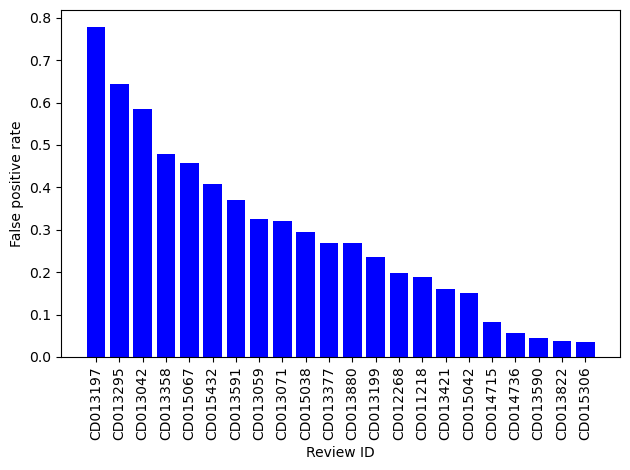

In [125]:
manual_search_result = manual_search_result.sort_values(by = "False positive", ascending = False)

plt.bar(manual_search_result['Review_ID'], manual_search_result['False positive'], color = 'blue')
plt.xlabel("Review ID")
plt.ylabel("False positive rate")
plt.xticks(rotation=90)
plt.tight_layout()

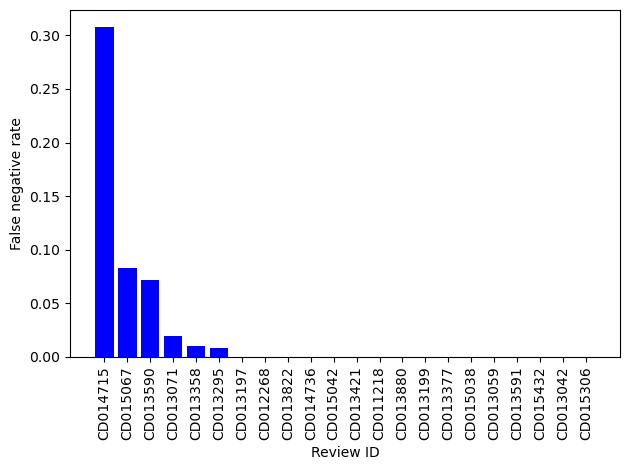

In [126]:
manual_search_result = manual_search_result.sort_values(by = "False negative", ascending = False)

plt.bar(manual_search_result['Review_ID'], manual_search_result['False negative'], color = 'blue')
plt.xlabel("Review ID")
plt.ylabel("False negative rate")
plt.xticks(rotation=90)
plt.tight_layout()

In [127]:
tmp = merged_df[["Review_ID", "Cochrane Review Group Code"]].copy()

In [128]:
tmp["Review_ID_prefix"] = tmp["Review_ID"].str.split('.').str[0]

In [129]:
tmp = tmp[["Review_ID_prefix","Cochrane Review Group Code"]].copy()

In [130]:
manual_search_result

,False positive,False negative,Review_ID,Publications Numbers
4,0.082523,0.308271,CD014715,49162
18,0.456712,0.083333,CD015067,2068
21,0.043860,0.071429,CD013590,1852
15,0.320283,0.019231,CD013071,9962
11,0.478943,0.010101,CD013358,3542
14,0.644937,0.008696,CD013295,3137
13,0.779430,0.000000,CD013197,2464
2,0.197023,0.000000,CD012268,4586
1,0.037102,0.000000,CD013822,10314
19,0.057680,0.000000,CD014736,6128


In [131]:
manual_search_result = manual_search_result.merge(tmp, left_on = "Review_ID", right_on = "Review_ID_prefix", how = "inner").copy()

In [132]:
manual_search_result["Review_ID_Cochrane_code"] = manual_search_result["Review_ID"] +" (" + manual_search_result["Cochrane Review Group Code"] + ")"

In [133]:
manual_search_result

,False positive,False negative,Review_ID,Publications Numbers,Review_ID_prefix,Cochrane Review Group Code,Review_ID_Cochrane_code
0,0.082523,0.308271,CD014715,49162,CD014715,Pregnancy and Childbirth,CD014715 (Pregnancy and Childbirth)
1,0.456712,0.083333,CD015067,2068,CD015067,Dementia and Cognitive Improvement,CD015067 (Dementia and Cognitive Improvement)
2,0.043860,0.071429,CD013590,1852,CD013590,Cystic Fibrosis and Genetic Disorders,CD013590 (Cystic Fibrosis and Genetic Disorders)
3,0.320283,0.019231,CD013071,9962,CD013071,Metabolic and Endocrine Disorders,CD013071 (Metabolic and Endocrine Disorders)
4,0.478943,0.010101,CD013358,3542,CD013358,Heart,CD013358 (Heart)
5,0.644937,0.008696,CD013295,3137,CD013295,Injuries,CD013295 (Injuries)
6,0.779430,0.000000,CD013197,2464,CD013197,Hepato-Biliary,CD013197 (Hepato-Biliary)
7,0.197023,0.000000,CD012268,4586,CD012268,Metabolic and Endocrine Disorders,CD012268 (Metabolic and Endocrine Disorders)
8,0.037102,0.000000,CD013822,10314,CD013822,Breast Cancer,CD013822 (Breast Cancer)
9,0.057680,0.000000,CD014736,6128,CD014736,Vascular,CD014736 (Vascular)


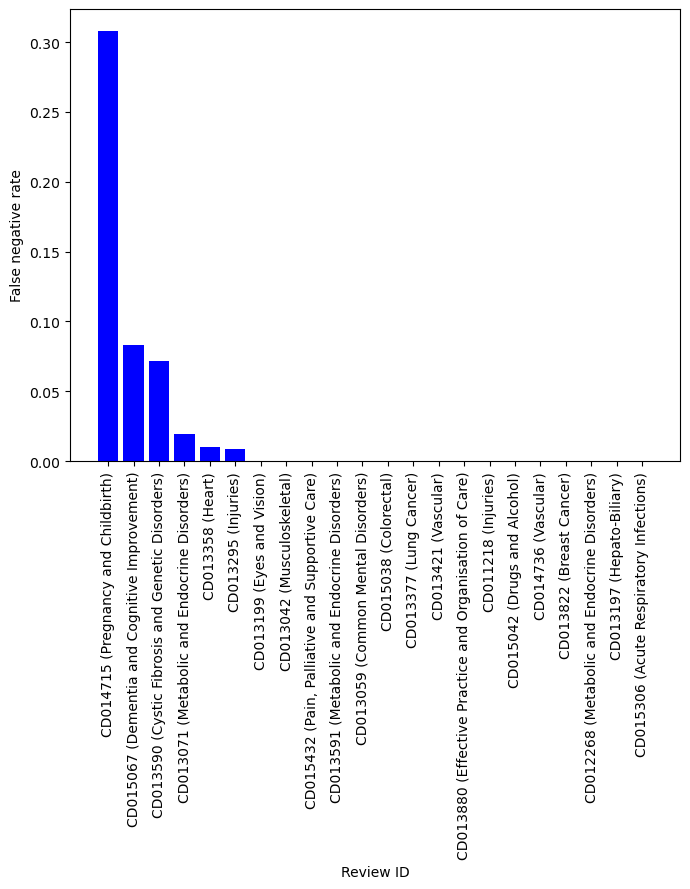

In [134]:
manual_search_result = manual_search_result.sort_values(by = "False negative", ascending = False)

plt.figure(figsize=(7, 9))
plt.bar(manual_search_result['Review_ID_Cochrane_code'], manual_search_result['False negative'], color = 'blue')
plt.xlabel("Review ID")
plt.ylabel("False negative rate")
plt.xticks(rotation=90)
plt.tight_layout()

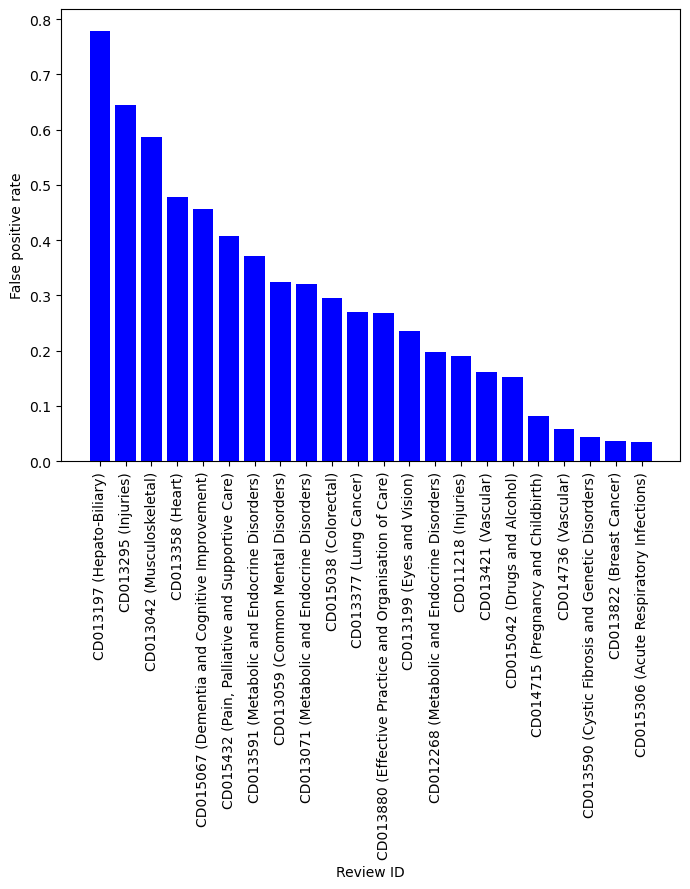

In [138]:
manual_search_result = manual_search_result.sort_values(by = "False positive", ascending = False)

plt.figure(figsize=(7, 9))
plt.bar(manual_search_result['Review_ID_Cochrane_code'], manual_search_result['False positive'], color = 'blue')
plt.xlabel('Review ID')
plt.ylabel("False positive rate")
plt.xticks(rotation=90)
plt.tight_layout()